# BSA Paper Plots

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from collections import OrderedDict
import numpy as np
import math
import pandas as pd
import pickle
import os
import seaborn as sns
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator
import matplotlib.font_manager

plt.rcParams["font.family"] = "Arial"
flatui = ["#e74c3c", "#2ecc71", "#34495e"]
cmap = sns.color_palette(flatui)
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib import markers
mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['font.size'] = 12
mpl.rc('xtick', labelsize=18) 
mpl.rc('ytick', labelsize=18) 
mpl.rc('axes', labelsize=20) 
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'
mpl.rcParams['lines.markersize'] = 10
classic_kwargs = {'s': 20, 'edgecolors': 'k', 'c': 'b'}
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
# def uniqueish_color():
#     """There're better ways to generate unique colors, but this isn't awful."""
#     return plt.cm.gist_ncar(np.random.random())

In [ ]:
import msprime, pyslim

tree_file = 'SLiM_NV_BSA.trees'
# read tree file
ts = pyslim.load(tree_file)
tree = ts.first()
all_samples = list(tree.samples())
chr_len = int(list(ts.trees())[-1].interval[-1])
genome_pop_size = len(all_samples)

## Functions for calculating the analytics of genomic resolution

In [2]:
"""
    Calculate the BSA open-window resolution in infinite populations
"""
def calc_BSA_open_win_res_inf(r, s, t):
    return 1/(r*s*t)

"""
    Calculate the BSA open-window resolution in finite populations
"""
def calc_BSA_open_win_res_fin(Ne, r, s, t):
    D = 1/(2*Ne*r*np.log((2*s*(np.exp(t/(4*Ne))-1)+1)))
    return D

"""
    Calculate the BSA open-window resolution in finite populations with recursion
"""
def calc_BSA_open_win_res_recursion(Ne, r, s, t):
    tot_tree_len_bef_3 = sum([calc_nt_recursion_diploid(Ne, t, s) for t in range(t-2)])
    samples_at_3 = calc_nt_recursion_diploid(Ne, t-2, s)
    D = 1/(r*samples_at_3+r/2*tot_tree_len_bef_3)
    return D

"""
    Calculate the HS open-window resolution in finite populations
"""
def calc_HS_open_win_res_fin(Ne, r, s, t):
    D = 1/(2*Ne*r*np.log((2*s*(np.exp((t)/(2*Ne))-1)+1)))
    return D

"""
    Calculate the HS open-window resolution in finite populations with recursion
"""
def calc_HS_open_win_res_fin_recursion(Ne, r, s, t):
    tot_tree_len_bef_2 = sum([calc_nt_recursion_diploid(Ne/2, t, s) for t in range(t-1)])
    D = 1/(r*tot_tree_len_bef_2)
    return D

"""
    Calculate the IM open-window resolution in finite populations
"""
def calc_IM_open_win_res_fin(Ne, r, s, t):
    D = 1/(Ne/2*r*np.log((2*s*(np.exp((t)/(Ne))-1)+1)))
    return D

"""
    Calculate the IM open-window resolution in finite populations with recursion
"""
def calc_IM_open_win_res_fin_recursion(Ne, r, s, t):
    harmonic_Ne = t/(((t/2)/(Ne/4))+((t/2)/Ne))
    tot_tree_len_bef_2 = sum([calc_nt_recursion_diploid(harmonic_Ne, t, s) for t in range(t-1)])
    D = 1/(r/2*tot_tree_len_bef_2)
    return D

In [3]:
"""    
    Calculate the number of lineages expectation
"""
def calc_nt_recursion_diploid(Ne, t, s):
    if (t == 0):
        return 2*s
    elif (t == 1):
        return 2*Ne - 2*Ne*(1-1/(2*Ne))**(2*s)
    else:
        return 2*Ne - 2*Ne*(1-1/(2*Ne))**(calc_nt_recursion_diploid(Ne, t-1, s))
    
"""    
    Calculate the number of lineages variance
"""
def calc_nt_recursion_diploid_variance(Ne, t, s):
    if (t == 0):
        return 0
    elif (t == 1):
        return 2*Ne*(1-1/(2*Ne))**(2*s)+2*Ne*(2*Ne-1)*(1-1/Ne)**(2*s)-4*Ne**2*(1-1/(2*Ne))**(4*s)
    else:
        variance = 2*Ne*(1-1/(2*Ne))**(calc_nt_recursion_diploid(Ne, t-1, s)) + \
                   2*Ne*(2*Ne-1)*(1-1/Ne)**(calc_nt_recursion_diploid(Ne, t-1, s)) + \
                   4*Ne**2*(1-1/(2*Ne))**(2*calc_nt_recursion_diploid(Ne, t-1, s))
        return variance


def calc_nt_diploid(Ne, t, s):
    return 2*s / (2*s - (2*s - 1)*np.exp(-t/(4*Ne)))

"""
    Calculate the BSA open-window resolution in finite populations
"""
def calc_nt_recursion_haploid(Ne, t, s):
    if (t == 0):
        return s
    elif (t == 1):
        return Ne - Ne*(1-1/(Ne))**(s)
    else:
        return Ne - Ne*(1-1/(Ne))**(calc_nt_recursion_haploid(Ne, t-1, s))
    
def calc_nt_haploid(Ne, t, s):
    return s / (s - (s - 1)*np.exp(-t/(2*Ne)))

## Plot BSA Summary Statistics
### One Summary Statistic ($G'$)

In [5]:
"""
    Smoothing functions for G and A_d
"""
def tricube_smooth_G(all_snp_g_dict, win_size=10000):
    """
        tricube_smooth_G(all_snp_g_dict, win_size=10000) smooths G statistic of each SNP using a tricube-weighted smoothing function
    """
    tricube_weighted_Gprime_dict = OrderedDict()
    min_ = min(all_snp_g_dict.keys())
    max_ = max(all_snp_g_dict.keys())
    all_snp_list = sorted(list(filter(lambda x : min_ < x < max_, all_snp_g_dict.keys())))
    for focal_snp in all_snp_list:
        window = (focal_snp - win_size//2, focal_snp + win_size//2)
        snp_in_window = list(filter(lambda x : window[0] <= x <= window[1], all_snp_list))
        weight_kjs_ = [(1-(abs(snp-focal_snp)/(win_size // 2))**3)**3 for snp in snp_in_window]
        sum_kjs = sum(weight_kjs_)
        weight_kjs_dict = OrderedDict([(snp, k_j / sum_kjs) for snp, k_j in zip(snp_in_window, weight_kjs_)])
        snp_Gprime = sum([weight_kjs_dict[snp] * all_snp_g_dict[snp] for snp in snp_in_window])

        for snp in snp_in_window:
            tricube_weighted_Gprime_dict[snp] = snp_Gprime
#             print(snp, snp_Gprime)
    # print("SNP G\' finished!", "--- %s seconds ---" % (time.time() - start_time))
    peak_snps = [x[0] for x in list(filter(lambda x: abs(x[1]-max(tricube_weighted_Gprime_dict.values()))<=0.01, tricube_weighted_Gprime_dict.items()))]
#     print(peak_snps)
#     print(np.min(peak_snps), np.max(peak_snps))
    resolution = np.max(peak_snps) - np.min(peak_snps)
    return(tricube_weighted_Gprime_dict, resolution)

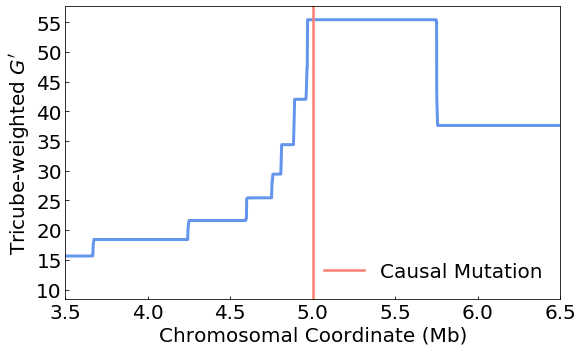

In [20]:
pckl_file = 'BSA_Resolution_vs_Statistics_1.0cM_Popsize_100_SampleSize_20.pckl'
with open(pckl_file, 'rb') as f:
    smoothed_dicts = pickle.load(f)

Ne = 100
R = '1e-8'
S = 20
T = 10

fig, ax = plt.subplots(1,1)
fig.set_size_inches((8.2,5))
ax.set_xlabel("Chromosomal Coordinate (Mb)", fontsize=20)
# ax.set_title("Simulated BSA Experiment\n$N_e$ = {}, $s$ = {}, $t$ = {}, $r$ = {}cM/Mb".format(Ne, S, T, float(R)/1e-8), fontsize=20)
for dicts in smoothed_dicts:
    smoothed_dict, tricube_weighted_Gprime_dict = dicts
    ax.plot(list(tricube_weighted_Gprime_dict.keys()), list(tricube_weighted_Gprime_dict.values()), linewidth=3,color='cornflowerblue')
    break
    
ax.set_ylabel("Tricube-weighted $\it{G\'}$", fontsize=20)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xlim(3.5e6-1, 6.5e6+1)
# ax.set_ylim(40, 56)
# ax.yaxis.set_ticks(np.arange(45, 60, 5))
#         axes[i-1].yaxis.set_ticks(np.arange(25, 65, 10))
#             axes[i-1].text(0.5, 0.15, 'Confidence Resolution\n{}%: {}Mb\n{}%: {}Mb\n{}%: {}Mb'.format(*[x for res in resolutions_percentile for x in res]), horizontalalignment='center', verticalalignment='center', fontsize=18, transform=axes[i-1].transAxes)

#     axes[i-1].legend(loc='best',fontsize=14)
#     axes[i-1].axvline(x=CAUSAL_MUT)
ax.yaxis.set_tick_params(labelsize=20)
ax.xaxis.set_tick_params(labelsize=20)
ax.set_xticklabels(ax.get_xticks())
ax.axvline(5e6, color='salmon', linewidth=2.5,label='Causal Mutation')

labels = [item.get_text() for item in ax.get_xticklabels()]
labels = [str(int(float(loc)) / 10**6) for loc in labels]
ax.set_xticklabels(labels)
ax.legend(fontsize=20, loc='best', frameon=False)
plt.tight_layout()
# plt.subplots_adjust(hspace = 0.2)
plt.savefig('BSA_Summary_Stats_Ne_100_1cM_G_Only',dpi=400)

(4980106, 5188881)
(4894568, 5102364)


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


(4817460, 5904286)


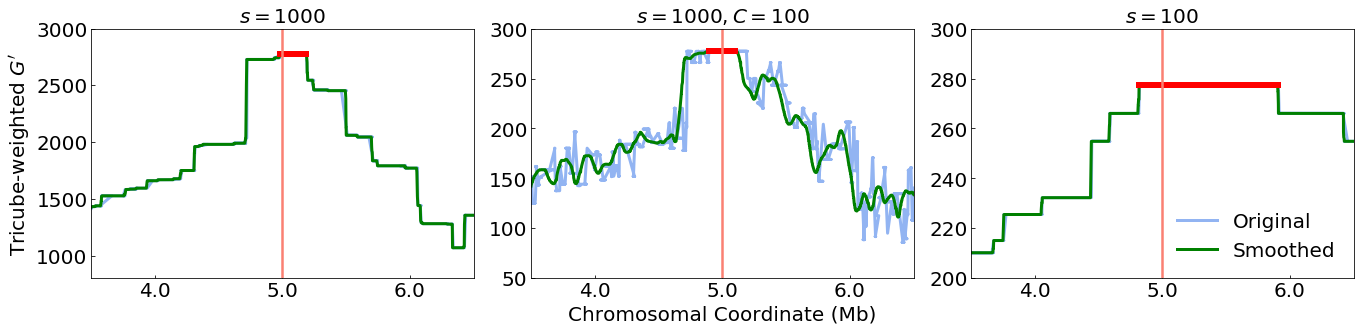

In [6]:
pckl_file = 'BSA_Resolution_vs_Statistics_SampleSize-1000_Coverage-100.pckl'
with open(pckl_file, 'rb') as f:
    smoothed_dicts = pickle.load(f)

Ne = 100
R = '1e-8'
S = 300
T = 10

fig, axes = plt.subplots(1,3)
fig.set_size_inches((19,5))
# ax.set_xlabel("Chromosomal Coordinate (Mb)", fontsize=20)
# ax.set_title("Simulated BSA Experiment\n$N_e$ = {}, $s$ = {}, $t$ = {}, $r$ = {}cM/Mb".format(Ne, S, T, float(R)/1e-8), fontsize=20)
# for dicts in smoothed_dicts:
tricube_weighted_Gprime_dict, tricube_weighted_Gprime_w_cov = smoothed_dicts
axes[0].plot(list(tricube_weighted_Gprime_dict.keys()), list(tricube_weighted_Gprime_dict.values()), linewidth=3,color='cornflowerblue', label='Original', alpha=0.7)
axes[1].plot(list(tricube_weighted_Gprime_w_cov.keys()), list(tricube_weighted_Gprime_w_cov.values()), linewidth=3,color='cornflowerblue', label='Original', alpha=0.7)

tricube_weighted_Gprime_w_cov = tricube_smooth_G(tricube_weighted_Gprime_w_cov, int(1e5))[0]
tricube_weighted_Gprime_dict = tricube_smooth_G(tricube_weighted_Gprime_dict)[0]
axes[0].plot(list(tricube_weighted_Gprime_dict.keys()), list(tricube_weighted_Gprime_dict.values()), linewidth=3,color='green', label='Smoothed')
axes[1].plot(list(tricube_weighted_Gprime_w_cov.keys()), list(tricube_weighted_Gprime_w_cov.values()), linewidth=3,color='green', label='Smoothed')

max_window = list(filter(lambda x: np.isclose(x[1],max(tricube_weighted_Gprime_dict.values())), tricube_weighted_Gprime_dict.items()))
max_window_bounds = (max_window[0][0], max_window[-1][0])
print(max_window_bounds)
# axes[0].axvline(max_window_bounds[0], ymin=0.92, ymax=0.98, color='red', linewidth=2.5)
# axes[0].axvline(max_window_bounds[1], ymin=0.92, ymax=0.98, color='red', linewidth=2.5)
axes[0].axhline(y=max(tricube_weighted_Gprime_dict.values()), xmin=(max_window_bounds[0]-3.5e6)/3e6, 
                xmax=(max_window_bounds[1]-3.5e6)/3e6, color='red', linewidth=6)
axes[0].set_ylim((800,3000))

max_window = list(filter(lambda x: np.isclose(x[1],max(tricube_weighted_Gprime_w_cov.values())), tricube_weighted_Gprime_w_cov.items()))
max_window_bounds = (max_window[0][0], max_window[-1][0])
print(max_window_bounds)
# axes[1].axvline(max_window_bounds[0], ymin=0.92, ymax=0.98, color='red', linewidth=2.5)
# axes[1].axvline(max_window_bounds[1], ymin=0.92, ymax=0.98, color='red', linewidth=2.5)
axes[1].axhline(y=max(tricube_weighted_Gprime_w_cov.values()), xmin=(max_window_bounds[0]-3.5e6)/3e6, 
                xmax=(max_window_bounds[1]-3.5e6)/3e6, color='red', linewidth=6)
axes[1].set_ylim((50,300))

pckl_file = 'BSA_Resolution_vs_Statistics_SampleSize-100_Coverage-None.pckl'
with open(pckl_file, 'rb') as f:
    smoothed_dicts = pickle.load(f)
tricube_weighted_Gprime_dict, tricube_weighted_Gprime_w_cov = smoothed_dicts
axes[2].plot(list(tricube_weighted_Gprime_dict.keys()), list(tricube_weighted_Gprime_dict.values()), linewidth=3,color='cornflowerblue', label='Original', alpha=0.7)
tricube_weighted_Gprime_dict = tricube_smooth_G(tricube_weighted_Gprime_dict)[0]
axes[2].plot(list(tricube_weighted_Gprime_dict.keys()), list(tricube_weighted_Gprime_dict.values()), linewidth=3,color='green', label='Smoothed')

max_window = list(filter(lambda x: np.isclose(x[1],max(tricube_weighted_Gprime_dict.values())), tricube_weighted_Gprime_dict.items()))
max_window_bounds = (max_window[0][0], max_window[-1][0])
print(max_window_bounds)
# axes[2].axvline(max_window_bounds[0], ymin=0.92, ymax=0.98, color='red', linewidth=2.5)
# axes[2].axvline(max_window_bounds[1], ymin=0.92, ymax=0.98, color='red', linewidth=2.5)
axes[2].axhline(y=max(tricube_weighted_Gprime_dict.values()), xmin=(max_window_bounds[0]-3.5e6)/3e6, 
                xmax=(max_window_bounds[1]-3.5e6)/3e6, color='red', linewidth=6)
axes[2].set_ylim((200,300))
axes[0].set_ylabel("Tricube-weighted $\it{G\'}$", fontsize=20)
axes[1].set_ylabel("", fontsize=20)
# ax.yaxis.set_major_locator(MaxNLocator(integer=True))

for ax in axes:
    ax.set_xlim(3.5e6-1, 6.5e6+1)
    ax.set_xticklabels(ax.get_xticks())
    ax.yaxis.set_tick_params(labelsize=20)
    ax.xaxis.set_tick_params(labelsize=20)

    labels = [item.get_text() for item in ax.get_xticklabels()]
    labels = [str(int(float(loc)) / 10**6) for loc in labels]
    ax.set_xticklabels(labels)
    ax.axvline(5e6, color='salmon', linewidth=2.5)
#     ax.axvline(5e6, color='salmon', linewidth=2.5,label='Causal Mutation')

axes[1].set_xlabel("Chromosomal Coordinate (Mb)", fontsize=20)
axes[2].legend(fontsize=20, loc='lower right', frameon=False)
# axes[2].legend(fontsize=15, loc='lower right', frameon=False)

axes[0].set_title("$s=1000$", fontsize=20)
axes[1].set_title("$s=1000, C=100$", fontsize=20)
axes[2].set_title("$s=100$", fontsize=20)
# plt.suptitle("Simulated BSA Experiment: $N_e$ = {}, $t$ = {}, $r$ = {}cM/Mb".format(Ne, T, float(R)/1e-8), fontsize=20)

plt.tight_layout()
plt.subplots_adjust(wspace = 0.15, top=0.85)
plt.savefig('BSA_Summary_Stats_Ne_100_1cM_s1e3_C100.pdf',dpi=400)

In [61]:
# pckl_file = 'BSA_Resolution_vs_Statistics_SampleSize-200_Coverage-None.pckl'
# with open(pckl_file, 'rb') as f:
#     smoothed_dicts = pickle.load(f)

# Ne = 100
# R = '1e-8'
# S = 300
# T = 10

# fig, ax = plt.subplots(1,1)
# fig.set_size_inches((8,6))
# ax.set_xlabel("Chromosomal Coordinate (Mb)", fontsize=20)
# ax.set_title("Simulated BSA Experiment\n$N_e$ = {}, $s$ = {}, $t$ = {}, $r$ = {}cM/Mb".format(Ne, S, T, float(R)/1e-8), fontsize=20)
# for dicts in smoothed_dicts:
#     smoothed_dict, tricube_weighted_Gprime_dict = dicts
#     ax.plot(list(tricube_weighted_Gprime_dict.keys()), list(tricube_weighted_Gprime_dict.values()), linewidth=3,color='cornflowerblue')
#     break
    
# ax.set_ylabel("Tricube-weighted $\it{G\'}$", fontsize=20)
# ax.yaxis.set_major_locator(MaxNLocator(integer=True))
# ax.set_xlim(3.5e6-1, 6.5e6+1)
# # ax.set_ylim(40, 56)
# # ax.yaxis.set_ticks(np.arange(45, 60, 5))
# #         axes[i-1].yaxis.set_ticks(np.arange(25, 65, 10))
# #             axes[i-1].text(0.5, 0.15, 'Confidence Resolution\n{}%: {}Mb\n{}%: {}Mb\n{}%: {}Mb'.format(*[x for res in resolutions_percentile for x in res]), horizontalalignment='center', verticalalignment='center', fontsize=18, transform=axes[i-1].transAxes)

# #     axes[i-1].legend(loc='best',fontsize=14)
# #     axes[i-1].axvline(x=CAUSAL_MUT)
# ax.yaxis.set_tick_params(labelsize=20)
# ax.xaxis.set_tick_params(labelsize=20)
# ax.set_xticklabels(ax.get_xticks())
# ax.axvline(5e6, color='salmon', linewidth=2.5,label='Causal Mutation')

# labels = [item.get_text() for item in ax.get_xticklabels()]
# labels = [str(int(float(loc)) / 10**6) for loc in labels]
# ax.set_xticklabels(labels)
# ax.legend(fontsize=20, loc='best', frameon=False)
# plt.tight_layout()
# # plt.subplots_adjust(hspace = 0.2)
# # plt.savefig('BSA_Summary_Stats_Ne_100_1cM_G_Only',dpi=200)

In [60]:
# pckl_file = 'BSA_Resolution_vs_Statistics_SampleSize-100_Coverage-None.pckl'
# with open(pckl_file, 'rb') as f:
#     smoothed_dicts = pickle.load(f)

# Ne = 100
# R = '1e-8'
# S = 300
# T = 10

# fig, ax = plt.subplots(1,1)
# fig.set_size_inches((8,6))
# ax.set_xlabel("Chromosomal Coordinate (Mb)", fontsize=20)
# ax.set_title("Simulated BSA Experiment\n$N_e$ = {}, $s$ = {}, $t$ = {}, $r$ = {}cM/Mb".format(Ne, S, T, float(R)/1e-8), fontsize=20)
# for dicts in smoothed_dicts:
#     smoothed_dict, tricube_weighted_Gprime_dict = dicts
#     ax.plot(list(tricube_weighted_Gprime_dict.keys()), list(tricube_weighted_Gprime_dict.values()), linewidth=3,color='cornflowerblue')
#     break
    
# ax.set_ylabel("Tricube-weighted $\it{G\'}$", fontsize=20)
# ax.yaxis.set_major_locator(MaxNLocator(integer=True))
# ax.set_xlim(3.5e6-1, 6.5e6+1)
# # ax.set_ylim(40, 56)
# # ax.yaxis.set_ticks(np.arange(45, 60, 5))
# #         axes[i-1].yaxis.set_ticks(np.arange(25, 65, 10))
# #             axes[i-1].text(0.5, 0.15, 'Confidence Resolution\n{}%: {}Mb\n{}%: {}Mb\n{}%: {}Mb'.format(*[x for res in resolutions_percentile for x in res]), horizontalalignment='center', verticalalignment='center', fontsize=18, transform=axes[i-1].transAxes)

# #     axes[i-1].legend(loc='best',fontsize=14)
# #     axes[i-1].axvline(x=CAUSAL_MUT)
# ax.yaxis.set_tick_params(labelsize=20)
# ax.xaxis.set_tick_params(labelsize=20)
# ax.set_xticklabels(ax.get_xticks())
# ax.axvline(5e6, color='salmon', linewidth=2.5,label='Causal Mutation')

# labels = [item.get_text() for item in ax.get_xticklabels()]
# labels = [str(int(float(loc)) / 10**6) for loc in labels]
# ax.set_xticklabels(labels)
# ax.legend(fontsize=20, loc='best', frameon=False)
# plt.tight_layout()
# # plt.subplots_adjust(hspace = 0.2)
# # plt.savefig('BSA_Summary_Stats_Ne_100_1cM_G_Only',dpi=200)

### Two Summary Statistics ($A_d$ and $G'$)

In [59]:
# ### Plot one simulation run

# pckl_file = 'BSA_Resolution_vs_Statistics_1.0cM_Popsize_100_SampleSize_20.pckl'
# with open(pckl_file, 'rb') as f:
#     smoothed_dicts = pickle.load(f)

# Ne = 100
# R = '1e-8'
# S = 20
# T = 10

# fig, axes = plt.subplots(2,1)
# fig.set_size_inches((8,6))
# # fig.suptitle("BSA Statistics", fontsize=24)
# # axes[-1].xaxis.set_major_locator(MaxNLocator(integer=True))
# axes[-1].set_xlabel("Chromosomal Coordinate (Mb)", fontsize=18)

# for dicts in smoothed_dicts:
#     smoothed_dict, tricube_weighted_Gprime_dict = dicts
#     color_ = uniqueish_color()
#     for i in range(1, len(axes)+1):
#         if (i == 1):
#             ancestry_windows = list(smoothed_dict.keys())
#             smoothed_ad = list(smoothed_dict.values())
#             axes[i-1].plot([win[0] for win in ancestry_windows], smoothed_ad, linewidth=3, color='#0485d1')
#         #         axes[i-1].legend(loc='best',fontsize=14)
            
#         if (i == 2):        
#             axes[i-1].plot(list(tricube_weighted_Gprime_dict.keys()), list(tricube_weighted_Gprime_dict.values()), linewidth=3,color='#0485d1')
#     break
# for i in range(1, len(axes)+1):
#     if (i == 1):
#         axes[i-1].set_ylabel("Smoothed $A_d$", fontsize=18)
#         axes[i-1].set_title("BSA Summary Statistics\n$N_e$ = {}, $s$ = {}, $t$ = {}, $r$ = {}cM/Mb".format(Ne, S, T, float(R)/1e-8), fontsize=22)
# #         axes[i-1].yaxis.set_major_locator(MaxNLocator(integer=True))
#         axes[i-1].set_xlim(4e6-1, 6e6+1)
#         axes[i-1].yaxis.set_ticks(np.arange(0.5, 1.05, 0.1))
# #         axes[i-1].yaxis.set_ticks(np.arange(0.7, 1, 0.1))
# #             axes[i-1].text(0.5, 0.15, 'Confidence Resolution\n{}%: {}Mb\n{}%: {}Mb\n{}%: {}Mb'.format(*[x for res in resolutions_percentile for x in res]), horizontalalignment='center', verticalalignment='center', fontsize=18, transform=axes[i-1].transAxes)
#     else:
#         axes[i-1].set_ylabel("Tricube-weighted $\it{G\'}$", fontsize=18)
#         axes[i-1].yaxis.set_major_locator(MaxNLocator(integer=True))
#         axes[i-1].set_xlim(4e6-1, 6e6+1)
#         axes[i-1].yaxis.set_ticks(np.arange(15, 61, 15))
# #         axes[i-1].yaxis.set_ticks(np.arange(25, 65, 10))
# #             axes[i-1].text(0.5, 0.15, 'Confidence Resolution\n{}%: {}Mb\n{}%: {}Mb\n{}%: {}Mb'.format(*[x for res in resolutions_percentile for x in res]), horizontalalignment='center', verticalalignment='center', fontsize=18, transform=axes[i-1].transAxes)

# #     axes[i-1].legend(loc='best',fontsize=14)
# #     axes[i-1].axvline(x=CAUSAL_MUT)
#     axes[i-1].yaxis.set_tick_params(labelsize=16)
#     axes[i-1].xaxis.set_tick_params(labelsize=16)
#     axes[i-1].set_xticklabels(axes[i-1].get_xticks())
#     axes[i-1].axvline(5e6, color='red', linewidth=2.5,label='Causal Mutation at 5.0Mb')

#     labels = [item.get_text() for item in axes[i-1].get_xticklabels()]
#     labels = [str(int(float(loc)) / 10**6) for loc in labels]
#     axes[i-1].set_xticklabels(labels)
# axes[1].legend(fontsize=14)
# plt.tight_layout()
# plt.subplots_adjust(hspace = 0.2)
# # plt.savefig('BSA_Summary_Stats_Ne_100_S_20_1cM',dpi=400)

## Solution Analysis (Plot of Analytics vs Sample Size, with different $N_e$ and $t$) 

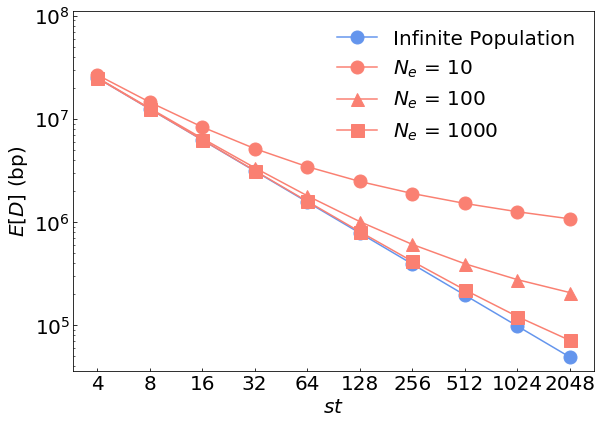

In [7]:
R = 1e-8
S_s = [2**x for x in range(1,11)]

T = 2
Nes = [10, 100, 1000]
fig, ax = plt.subplots()
fig.set_size_inches((8.5,6))
# axes[0].set_title("BSA Genomic Resolution: $t$ = {}, $r$ = {}cM/Mb".format(T, float(R)/1e-8), fontsize=23)
resolutions_inf = [calc_BSA_open_win_res_inf(float(R), S, T) for S in S_s]
ax.plot([str(s*T) for s in S_s], resolutions_inf, '-o', markersize=13, label='Infinite Population', color='cornflowerblue')
markers = ['-o', '-^', '-s']

for Ne in Nes:
    resolutions = [calc_BSA_open_win_res_fin(Ne, float(R), S, T) for S in S_s]
    ax.plot([str(s*T) for s in S_s], resolutions, markers[Nes.index(Ne)], markersize=13, label='$N_e$ = %s' % Ne, color='salmon')
    ax.set_xlabel("$st$", fontsize=20)
    ax.xaxis.set_tick_params(labelsize=20)
    ax.set_ylabel("$E[D]$ (bp)", fontsize=20)
    ax.set_yscale('log', basey=10)
    ax.set_ylim((None, 10**7+1*10**8))
    ax.yaxis.set_tick_params(labelsize=20)
ax.legend(markerscale=1, loc='best', fontsize=20, frameon=False)

# Ne = 100
# Ts = [5, 10, 20]
# # axes[1].set_title("BSA Genomic Resolution: $N_e$ = {}, $r$ = {}cM/Mb".format(Ne, float(R)/1e-8), fontsize=23)
# markers = ['-o', '-^', '-s']
# for T in Ts:
#     resolutions = [open_window_resolution_mean(Ne, float(R), S, T) for S in S_s]
#     print(Ne, float(R), T, ':\n', resolutions)
#     axes[1].plot([str(s) for s in S_s], resolutions, markers[Ts.index(T)], markersize=12, label='$t$ = %s' % T, color='salmon')
#     axes[1].set_xlabel("Sample Size $s$", fontsize=25)
#     axes[1].xaxis.set_tick_params(labelsize=25)
#     axes[1].set_yscale('log', basey=10)
#     axes[1].yaxis.set_tick_params(labelsize=25)

# axes[1].legend(markerscale=1, loc='lower left', fontsize=25, frameon=False)

plt.tight_layout()
# plt.subplots_adjust(wspace = 0.15)
plt.savefig('BSA_Resolution_Analytics_Cannings_for_Paper.pdf', dpi=400)

## BSA Numerical Validation ($N_e$)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


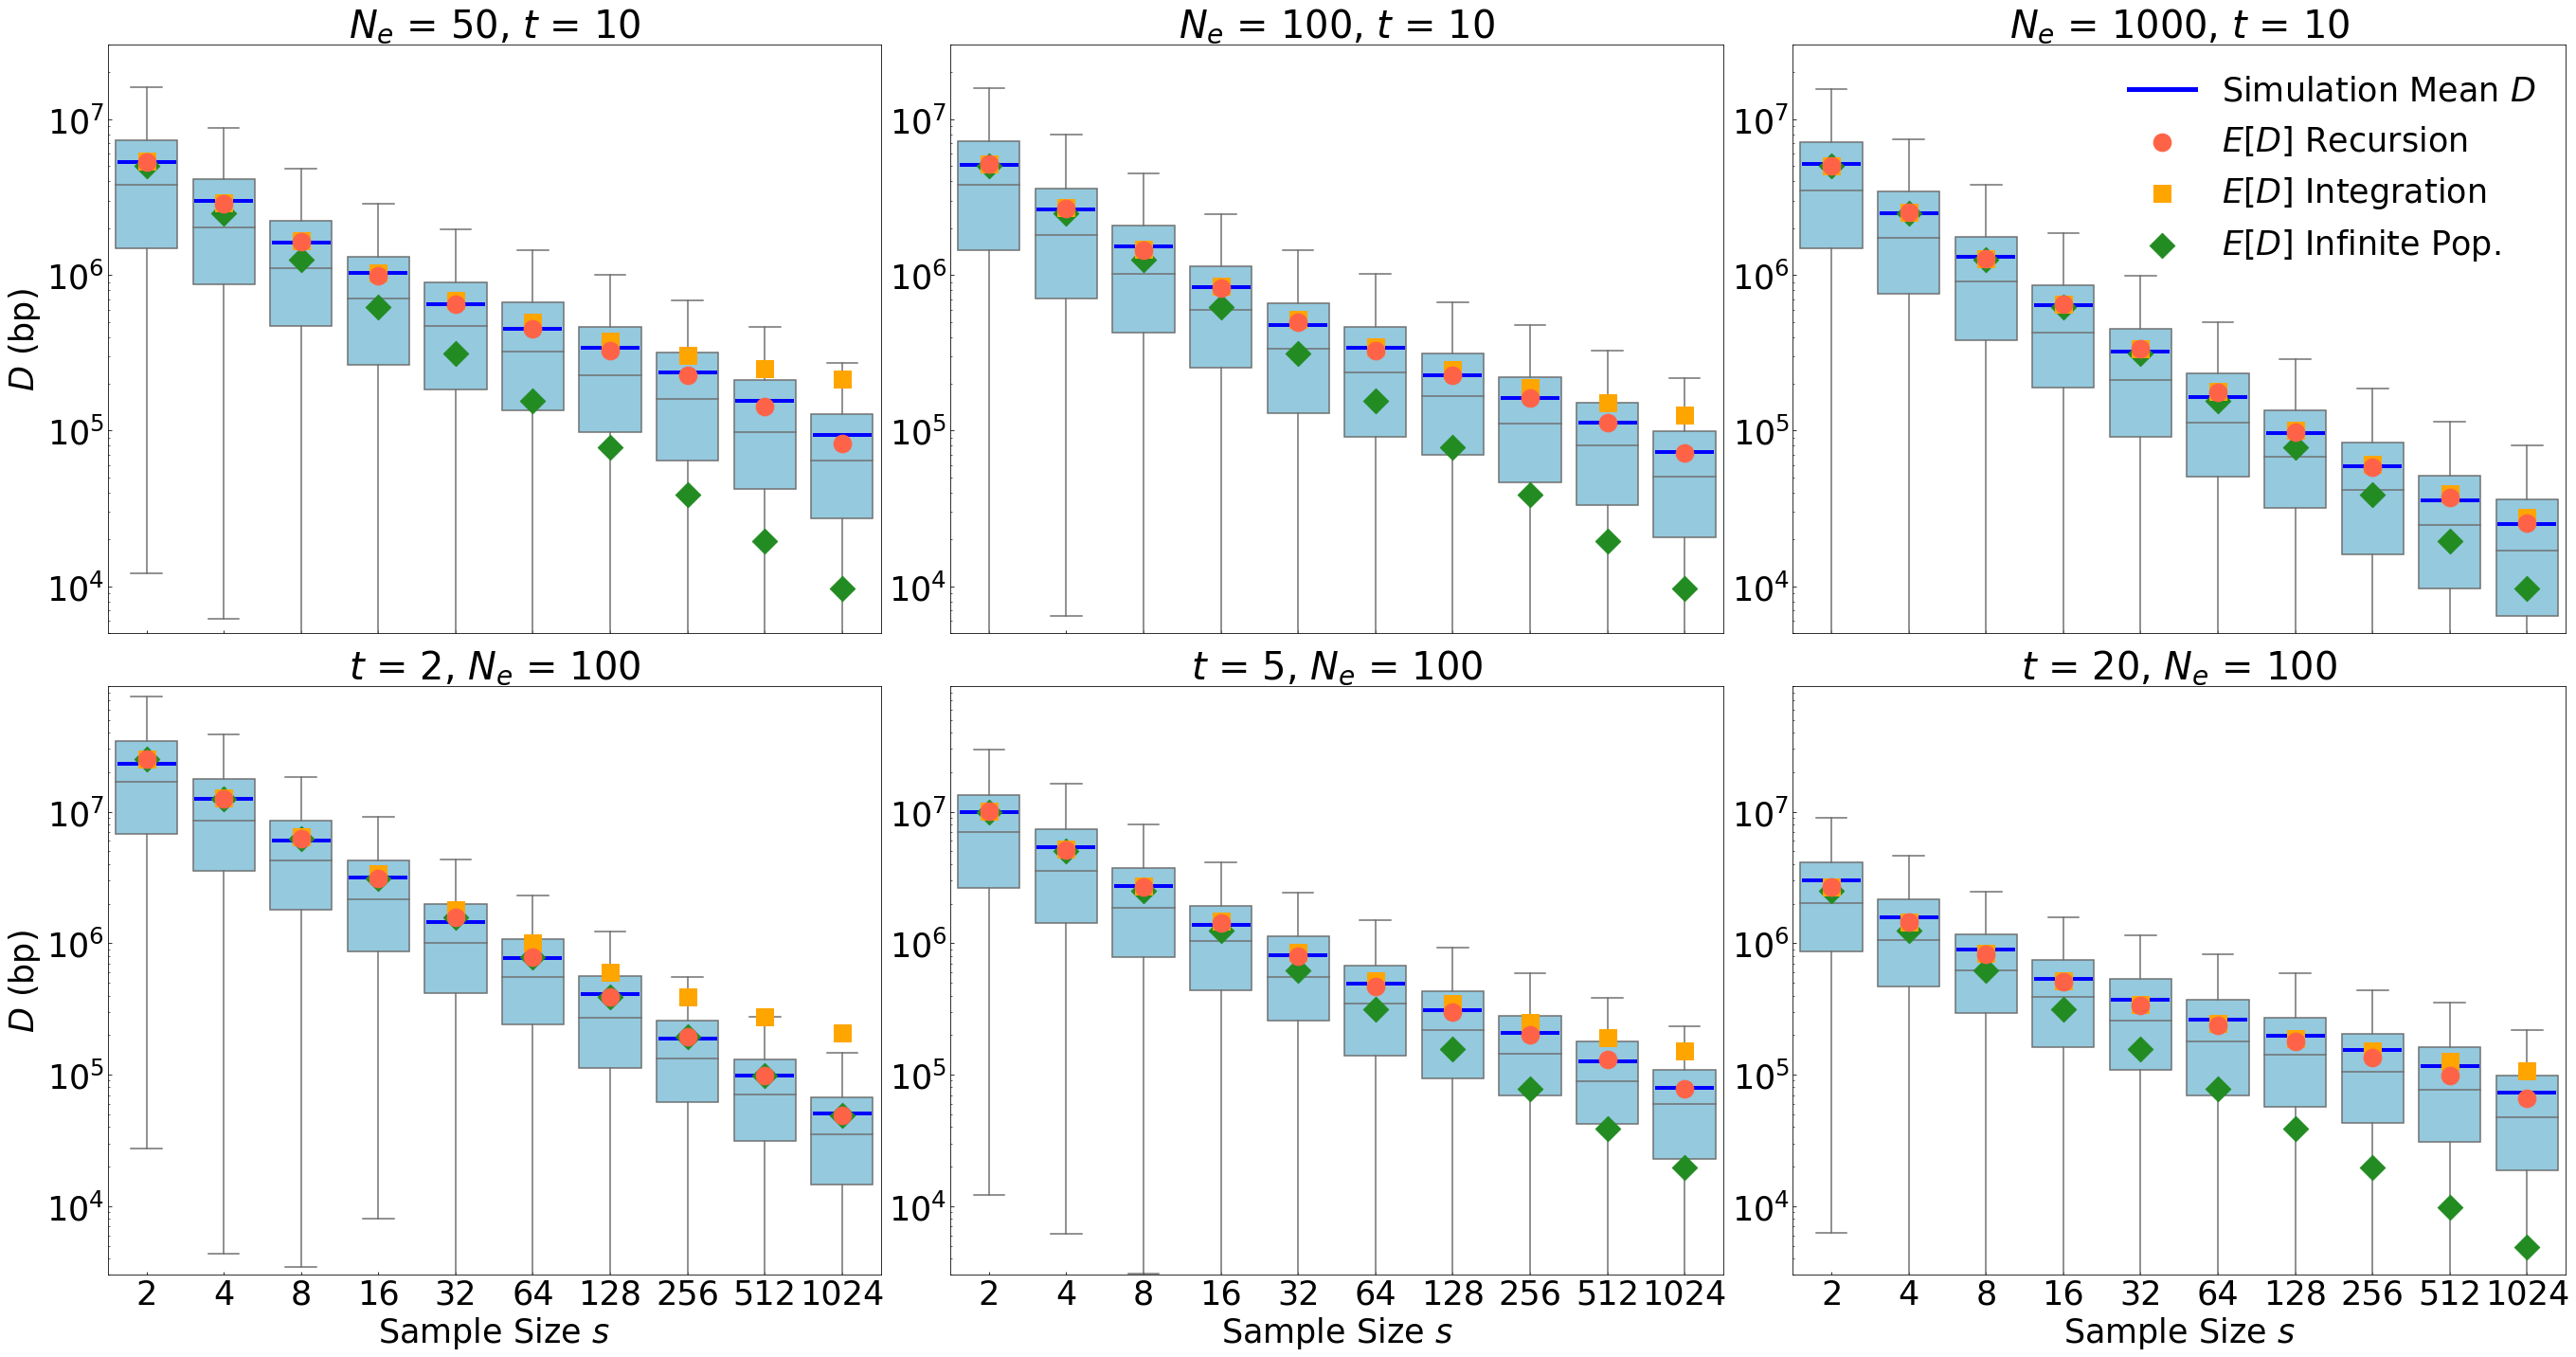

In [8]:
R = 1e-8
S_s = [2**x for x in range(1,11)]
gs = [2, 5, 20]
Nes = [50, 100, 1000]
fig, axes = plt.subplots(2,3)
fig.set_size_inches((38,20))
# fig.suptitle("BSA Genomic Resolution vs Sample Size", fontsize=50)
for row_idx in range(2):
    for col_idx in range(3):
        if (row_idx == 0):
            T = 10
            ax = axes[row_idx, col_idx]
            Ne = Nes[col_idx]
            # title
            ax.set_title('$N_e$ = {}, $t$ = {}'.format(Ne,T), fontsize=40)
            pckl_file = 'BSA_Open-win_Res_100MbChrom_Ne{}_Gen11_1.0cM_1kSims.pckl'.format(Ne)
        else:
            ax = axes[row_idx, col_idx]
            T = gs[col_idx]
            Ne = 100
            # title
            ax.set_title('$t$ = {}, $N_e$ = {}'.format(T, Ne,float(R)/1e-8), fontsize=40)
            pckl_file = 'BSA_Open-win_Res_100MbChrom_Ne100_Gen{}_1.0cM_1kSims.pckl'.format(T+1, Ne)
        
        with open(pckl_file, 'rb') as f: 
            resolution_all = pickle.load(f)     
        # Plot the data
        sample_sizes = []
        simulation_resolutions = []
        resolution_arrays = []
        for S, resolution in resolution_all.items():
            res = np.array(resolution)
            res = res[res!=np.inf]
            simulation_resolutions += list(res)
            sample_sizes += [S] * len(res)
            resolution_arrays.append(res)

        dict_ = {'Sample_size': sample_sizes, 'resolution': simulation_resolutions}
        df_ = pd.DataFrame(dict_)
        resolutions = np.array([calc_BSA_open_win_res_fin(Ne, float(R), S, T) for S in S_s])
#         print('\n', Ne, float(R), T,)
#         print('Approx:', resolutions)
        resolutions_ = np.array([calc_BSA_open_win_res_recursion(Ne, float(R), S, T) for S in S_s])
#         print('Recursion:', resolutions_)
#         print('Recursion difference:\n', resolutions_-resolutions)
        resolutions_inf = [calc_BSA_open_win_res_inf(float(R), S, T) for S in S_s]
        simulation_means = [np.mean(df_[df_['Sample_size'] == s]['resolution']) for s in S_s]
#         print('Simulations:', simulation_means)
        error = np.abs(np.divide(np.array(resolutions) - np.array(simulation_means), np.array(simulation_means)))
#         print(Ne, S, T, '% Error: ', np.mean(error), np.std(error))
        
        # Plot the data
        sns.boxplot(x="Sample_size", y="resolution", data=df_, ax=ax, color="skyblue", showfliers=False, showmeans=True, 
                   meanprops={"marker":"_","markeredgecolor":"blue", "mew":4, "markersize":62})
        ax.scatter(range(0, len(S_s)), resolutions_inf, marker='D', s=350,label='$E[D]$ Infinite Pop.', color='forestgreen',zorder=10)
        ax.scatter(range(0, len(S_s)), resolutions, marker='s', s=300,label='$E[D]$ Integration', color='orange', zorder=10)
        ax.scatter(range(0, len(S_s)), resolutions_, marker='o', s=350, color='tomato', label='$E[D]$ Recursion',zorder=10)
#         ax.scatter(range(0, len(S_s)), simulation_means, marker='o', s=300, color='b', label='Simulation Mean $D$')
        ax.set_yscale('log', basey=10)
        
        ax.yaxis.set_tick_params(labelsize=35)
        ax.xaxis.set_tick_params(labelsize=35)
        
        if (col_idx == 0):
            ax.set_ylabel("$D$ (bp)", fontsize=35)
        else:
            ax.set_ylabel("")
            
        if (row_idx == 1):
            ax.set_ylim((10**4-7e3, 10**7+8e7))
            ax.set_xlabel("Sample Size $s$", fontsize=35)
        else:
            ax.set_ylim((10**4-5e3, 10**7+2e7))
            ax.set_xlabel("")
            ax.set_xticklabels('')
# Legends
handles, labels = ax.get_legend_handles_labels()
handles += [Line2D([0], [0], color='b', linewidth=5, marker='_')]
labels += ['Simulation Mean $D$']
order = [3,2,1,0]
axes[0,2].legend([handles[idx] for idx in order],[labels[idx] for idx in order],markerscale=1, loc='upper right',frameon=False,fontsize=35)

plt.tight_layout()
plt.subplots_adjust(hspace=0.09, wspace = 0.09)
plt.savefig('BSA_Resolution_vs_S_100Mb_NV.pdf', dpi=400)

## Other Experiments Numerical Validation

### BC vs IM Numerical Validation

[2680252.41653192, 1454717.2996013537, 834693.9588588973, 514914.7115552341, 343815.4836035709, 247129.79578522049]
[3395818.05, 1561553.765, 910696.45, 529495.3, 342792.446, 233510.877]


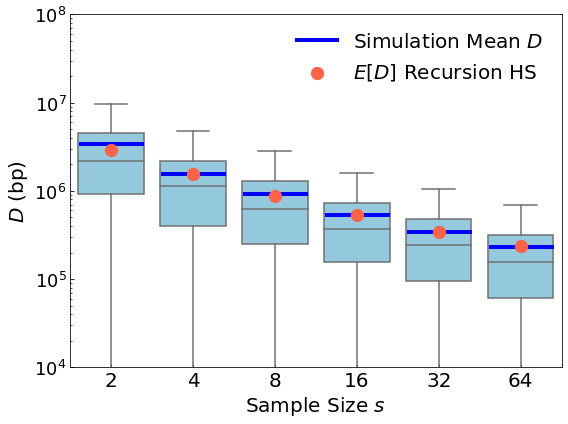

In [70]:
R = 1e-8
T = 10
S_s = [2**x for x in range(1,7)]
Ne = 100
fig, axes = plt.subplots()
fig.set_size_inches((8,6))

pckl_file = 'HC_Open-win_Res_100MbChrom_Ne100_Gen11_1.0cM_1kSims.pckl'
with open(pckl_file, 'rb') as f: 
    resolution_all = pickle.load(f)

# Plot the data
sample_sizes = []
simulation_resolutions = []
resolution_arrays = []
for S, resolution in resolution_all.items():
    res = np.array(resolution)
    res = res[res!=np.inf]
    simulation_resolutions += list(res)
    sample_sizes += [S] * len(res)
    resolution_arrays.append(res)

# print(resolution_arrays)
dict_ = {'Sample_size': sample_sizes, 'resolution': simulation_resolutions}
df_ = pd.DataFrame(dict_)
resolutions = [calc_HS_open_win_res_fin(Ne, float(R), S, T) for S in S_s]
resolutions_ = np.array([calc_HS_open_win_res_fin_recursion(Ne, float(R), S, T) for S in S_s])
simulation_means = [np.mean(df_[df_['Sample_size'] == s]['resolution']) for s in S_s]
print(resolutions)
print(simulation_means)

# Plot the data
# sns.boxplot(x="Sample_size", y="resolution", data=df_, ax=axes[1], color="mistyrose", showfliers=False)
sns.boxplot(x="Sample_size", y="resolution", data=df_, ax=axes, color="skyblue", showfliers=False, showmeans=True, 
                   meanprops={"marker":"_","markeredgecolor":"blue", "mew":4, "markersize":65})
axes.scatter(range(0, len(S_s)), resolutions_, marker='o', s=150, color='tomato', label='$E[D]$ Recursion HS',zorder=10)
# axes.scatter(range(0, len(S_s)), resolutions, marker='s', s=150, color='orange', label='HS $E[D]$ (Finite Pop.)')
# axes.scatter(range(0, len(S_s)), simulation_means,  s=150, marker='o', color='b', label='Simulation Mean $D$')

axes.set_ylabel("$D$ (bp)", fontsize=20)
axes.set_yscale('log', basey=10)
axes.set_ylim((10**4, 10**8))

axes.set_xlabel("Sample Size $s$", fontsize=20)
axes.xaxis.set_tick_params(labelsize=20)

handles, labels = axes.get_legend_handles_labels()
handles += [Line2D([0], [0], color='b', linewidth=4, marker='_')]
labels += ['Simulation Mean $D$']
order = [1,0]
axes.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
            markerscale=1, loc='upper right',frameon=False,fontsize=20)

plt.tight_layout()
plt.subplots_adjust(wspace = 0.05)
plt.savefig('Open-window_Res_vs_S_100Mb_HS.png', dpi=400)

[5695762.84750048, 3275958.10636077, 2026677.8071262632, 1357104.635255419, 977884.9850918752, 748638.5866402526]
[5540350.0, 2751520.0, 1739350.0, 1030100.0, 659910.0, 486470.0]


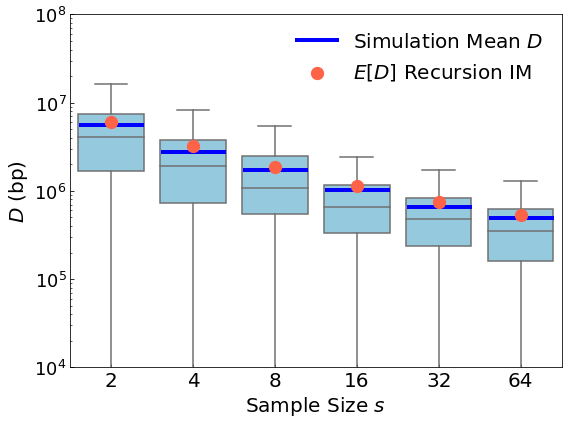

In [92]:
R = 1e-8
T = 10
S_s = [2**x for x in range(1,7)]
Ne = 100
fig, axes = plt.subplots()
fig.set_size_inches((8,6))

pckl_file = 'IM_Open-win_Res_100MbChrom_Ne100_1.0cM_Non-TreeSeq.pckl'
with open(pckl_file, 'rb') as f: 
    resolution_all = pickle.load(f)

# Plot the data
sample_sizes = []
simulation_resolutions = []
resolution_arrays = []
for S, resolution in resolution_all.items():
    res = np.array(resolution)
    res = res[res!=np.inf]
    simulation_resolutions += list(res)
    sample_sizes += [S] * len(res)
    resolution_arrays.append(res)

# print(resolution_arrays)
dict_ = {'Sample_size': sample_sizes, 'resolution': simulation_resolutions}
df_ = pd.DataFrame(dict_)
resolutions = [calc_IM_open_win_res_fin(Ne, float(R), S, T) for S in S_s]
resolutions_ = np.array([calc_IM_open_win_res_fin_recursion(Ne, float(R), S, T) for S in S_s])
simulation_means = [np.mean(df_[df_['Sample_size'] == s]['resolution']) for s in S_s]
print(resolutions)
print(simulation_means)

# Plot the data
# sns.boxplot(x="Sample_size", y="resolution", data=df_, ax=axes[1], color="mistyrose", showfliers=False)
sns.boxplot(x="Sample_size", y="resolution", data=df_, ax=axes, color="skyblue", showfliers=False, showmeans=True, 
                   meanprops={"marker":"_","markeredgecolor":"blue", "mew":4, "markersize":65})
axes.scatter(range(0, len(S_s)), resolutions_, marker='o', s=150, color='tomato', label='$E[D]$ Recursion IM', zorder=10)
# axes.scatter(range(0, len(S_s)), resolutions, marker='s', s=150, color='orange', label='IM $E[D]$ (Finite Pop.)')
# axes.scatter(range(0, len(S_s)), simulation_means,  s=150, marker='o', color='b', label='Simulation Mean $D$')

axes.set_ylabel("$D$ (bp)", fontsize=20)
axes.set_yscale('log', basey=10)
axes.set_ylim((10**4, 10**8))

axes.set_xlabel("Sample Size $s$", fontsize=20)
axes.xaxis.set_tick_params(labelsize=20)

handles, labels = axes.get_legend_handles_labels()
handles += [Line2D([0,0.5], [0,0.5], color='b', linewidth=4, marker='_')]
labels += ['Simulation Mean $D$']
order = [1,0]
axes.legend([handles[idx] for idx in order],[labels[idx] for idx in order],markerscale=1, loc='upper right',frameon=False,fontsize=20)

plt.tight_layout()
plt.subplots_adjust(wspace = 0.05)
plt.savefig('Open-window_Res_vs_S_100Mb_IM.png', dpi=400)

### @Deprecated: investigate the recursion solutions

In [31]:
# import msprime, tskit

# Ne = 100
# s = 1024
# fig, axes = plt.subplots(1,2, sharey=True)
# fig.set_size_inches((14,6))

# ### t = 5
# t = 5
# print('Run BSA for %d generations: \n' % t)
# # all_lineages = []
# # for sim in range(1000):
# #     tree_sequence = msprime.simulate(sample_size=2*s, Ne=100)
# #     tree = tree_sequence.first()
# #     # print(tree.draw(format="unicode"))
# #     time_list = []
# #     for i in range(2*s):
# #         u = i
# #         while u != tskit.NULL:
# #             time_list.append(tree.time(u))
# #             u = tree.parent(u)

# #     num_lineages = []
# #     for t_ in range(t+1):
# #         if (t_ == 0):
# #             num_lineages.append(len(list(filter(lambda x: x == t_, time_list))))
# #         else:
# #             num_lineages.append(num_lineages[-1] - len(set(filter(lambda x: t_-1 < x <= t_, time_list))))
# #     axes[1].plot(range(t+1), num_lineages, alpha=0.2, color='y')
# #     all_lineages.append(num_lineages)

# # msprime_est = np.array(all_lineages).mean(axis=0)
# approx_est = list(map(lambda t_: calc_nt_diploid(Ne, t_, s), range(0, t+1)))
# axes[1].plot(range(t+1), approx_est, alpha=1, color='r', label='Diff. Approx E[n(t)]')
# recursion_est = list(map(lambda t_: calc_nt_recursion_diploid(Ne, t_, s), range(0, t+1)))
# axes[1].plot(range(t+1), recursion_est, alpha=1, color='b', label='Recursion Exact E[n(t)]')
# axes[1].legend()
# # print('Simulation results: ', msprime_est)
# approx_est = list(map(lambda t_: calc_nt_diploid(Ne, t_, s), range(0, t+1)))
# print('Diff. Approx: ', np.array(approx_est))
# recursion_est = list(map(lambda t_: calc_nt_recursion_diploid(Ne, t_, s), range(0, t+1)))
# print('Exact Recursion: ', np.array(recursion_est))
# # print('Diff between simulations and approx: ', msprime_est - approx_est)
# # print('Diff between simulations and exact: ', msprime_est - recursion_est)

# ### t = 20
# t = 20
# print('Run BSA for %d generations: \n' % t)
# # all_lineages = []
# # for sim in range(1000):
# #     tree_sequence = msprime.simulate(sample_size=2*s, Ne=100)
# #     tree = tree_sequence.first()
# #     # print(tree.draw(format="unicode"))
# #     time_list = []
# #     for i in range(2*s):
# #         u = i
# #         while u != tskit.NULL:
# #             time_list.append(tree.time(u))
# #             u = tree.parent(u)

# #     num_lineages = []
# #     for t_ in range(t+1):
# #         if (t_ == 0):
# #             num_lineages.append(len(list(filter(lambda x: x == t_, time_list))))
# #         else:
# #             num_lineages.append(num_lineages[-1] - len(set(filter(lambda x: t_-1 < x <= t_, time_list))))
# #     axes[0].plot(range(t+1), num_lineages, alpha=0.2, color='y')
# #     all_lineages.append(num_lineages)
# # msprime_est = np.array(all_lineages).mean(axis=0)

# approx_est = list(map(lambda t_: calc_nt_diploid(Ne, t_, s), range(0, t+1)))
# axes[0].plot(range(t+1), approx_est, alpha=1, color='r', label='Diff. Approx E[n(t)]')
# recursion_est = list(map(lambda t_: calc_nt_recursion_diploid(Ne, t_, s), range(0, t+1)))
# axes[0].plot(range(t+1), recursion_est, alpha=1, color='b', label='Recursion Exact E[n(t)]')
# # np.array(all_lineages).mean(axis=0) - recursion_est
# # print('Simulation results: ',msprime_est)
# approx_est = list(map(lambda t_: calc_nt_diploid(Ne, t_, s), range(0, t+1)))
# print('Diff. Approx: ',np.array(approx_est))
# recursion_est = list(map(lambda t_: calc_nt_recursion_diploid(Ne, t_, s), range(0, t+1)))
# print('Exact Recursion: ',np.array(recursion_est))

In [32]:
# """
#     Calculate the BSA open-window resolution in finite populations
# """
# def int_under_curve(Ne, r, s, t):
#     D = (2*s)/(2*s-(2*s-1)*np.exp(-(t-2)/(4*Ne)))+2*Ne*np.log((2*s*(np.exp((t-2)/(4*Ne))-1)+1))
#     return D

# """
#     Calculate the BSA open-window resolution in finite populations with recursion
# """
# def recursion_sums(Ne, r, s, t):
#     tot_tree_len_bef_3 = sum([calc_nt_recursion_diploid(Ne, t, s) for t in range(t-2)])
#     samples_at_3 = calc_nt_recursion_diploid(Ne, t-2, s)
#     D = samples_at_3+tot_tree_len_bef_3/2
#     return D

# from matplotlib.ticker import FormatStrFormatter
# Ne, r, s, t = 100, 1e-8, 10, 50
# recursion_sums = np.array(list(map(lambda t: recursion_sums(Ne, r, s, t), range(2, t+1))))
# approx_int = np.array(list(map(lambda t: int_under_curve(Ne, r, s, t), range(2, t+1))))
# fig, ax = plt.subplots(1,2)
# fig.set_size_inches((14,6))
# ax[0].plot(range(2, t+1), abs(1/recursion_sums - 1/approx_int), color='r', label='abs(1/Recursion - 1/Approx.)')
# ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.1e'))
# ax[1].plot(range(2, t+1), abs(recursion_sums - approx_int), color='r', label='abs(Recursion - Approx.)')
# ax[0].legend()
# ax[1].legend()
# ax[0].set_xlabel('Generation')
# ax[1].set_xlabel('Generation')